# Importing Pytorch and setting up device-agnostic code
> Let's get Pytorch loaded and then follow best practice to setup our code to be device-agnostic.

In [4]:
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.4.0+cu121'

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [2]:
!pip install torchinfo

In [3]:
import torchinfo

In [6]:
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)
    torch.manual_seed(seed) # cpu 연산 무작위 고정
    torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
    torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )


# global variables

In [7]:
import easydict
args = easydict.EasyDict()

args.NUM_EPOCHS = 15
args.NUM_TRIALS = 5

args.vgg_best_model = 'best_vgg_model.pt'
args.resnet_best_model = 'best_resnet_model.pt'

# Get data
> We're going to be using our own custom dataset of pizza, steak and sushi images.

In [8]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # data/pizza_steak_sushi

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


# Load Data
> At the beginning od any new machine learning problem, it's paramount to understand the data your're working with. Here we'll take some steps to figure out what data we have.

In [9]:
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [10]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [11]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualize an image

Random image path: data/pizza_steak_sushi/train/steak/3518960.jpg
Image class: steak
Image height: 512
Image width: 384


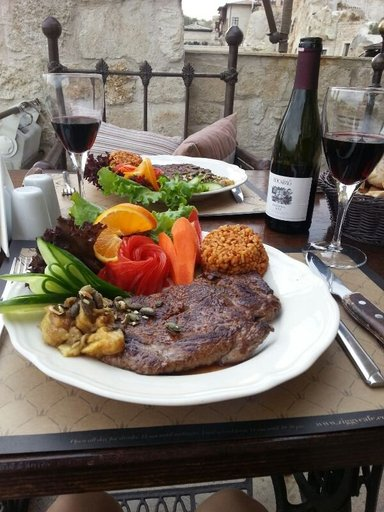

In [12]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

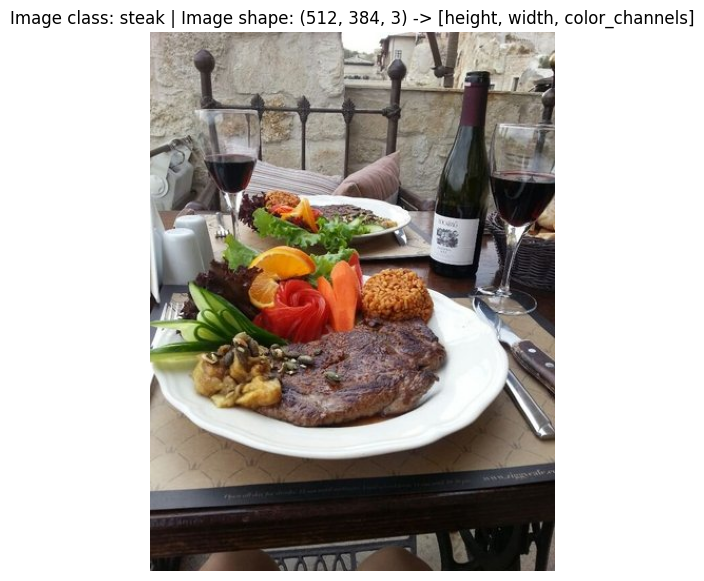

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# Dataset

## Create transform with data augmentation

In [14]:
sample_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Turn image folders into Datasets
sample_dataset = datasets.ImageFolder(train_dir, transform=sample_transform)
sample_dataset

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [15]:
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()

    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()

    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

mean_, std_ = calculate_norm(sample_dataset)
print(f'평균(R,G,B): {mean_}\n표준편차(R,G,B): {std_}')

평균(R,G,B): (0.5354544, 0.41756177, 0.3301338)
표준편차(R,G,B): (0.22768107, 0.22967243, 0.21931246)


In [16]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean_, std_)
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean_, std_)
])

## Create Dataset

In [17]:
# Turn image folders into Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=(0.5354544, 0.41756177, 0.3301338), std=(0.22768107, 0.22967243, 0.21931246))
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=(0.5354544, 0.41756177, 0.3301338), std=(0.22768107, 0.22967243, 0.21931246))
            ))

# DataLoader

In [18]:
# Turn Datasets into DataLoader's
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader = DataLoader(train_dataset,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7eb4b4b736a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7eb4b4b71e40>)

# TinyVGG
> By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model.

## What is VGG16?
- 옥스포트 대학의 연구팀 VGG에 의해 개발된 모델로써, 2014년 이미지넷 이미지 인식 대회에서 준우승을 한 모델이다.    
- 1등을 한 GoogleNet보다 단순하면서 성능은 거의 차이가 나지 않은 VGG가 주목을 많이 받았습니다.
  - VGG network 구성: 16 layers(convolution + fully nected)로 구성되어 있다.  

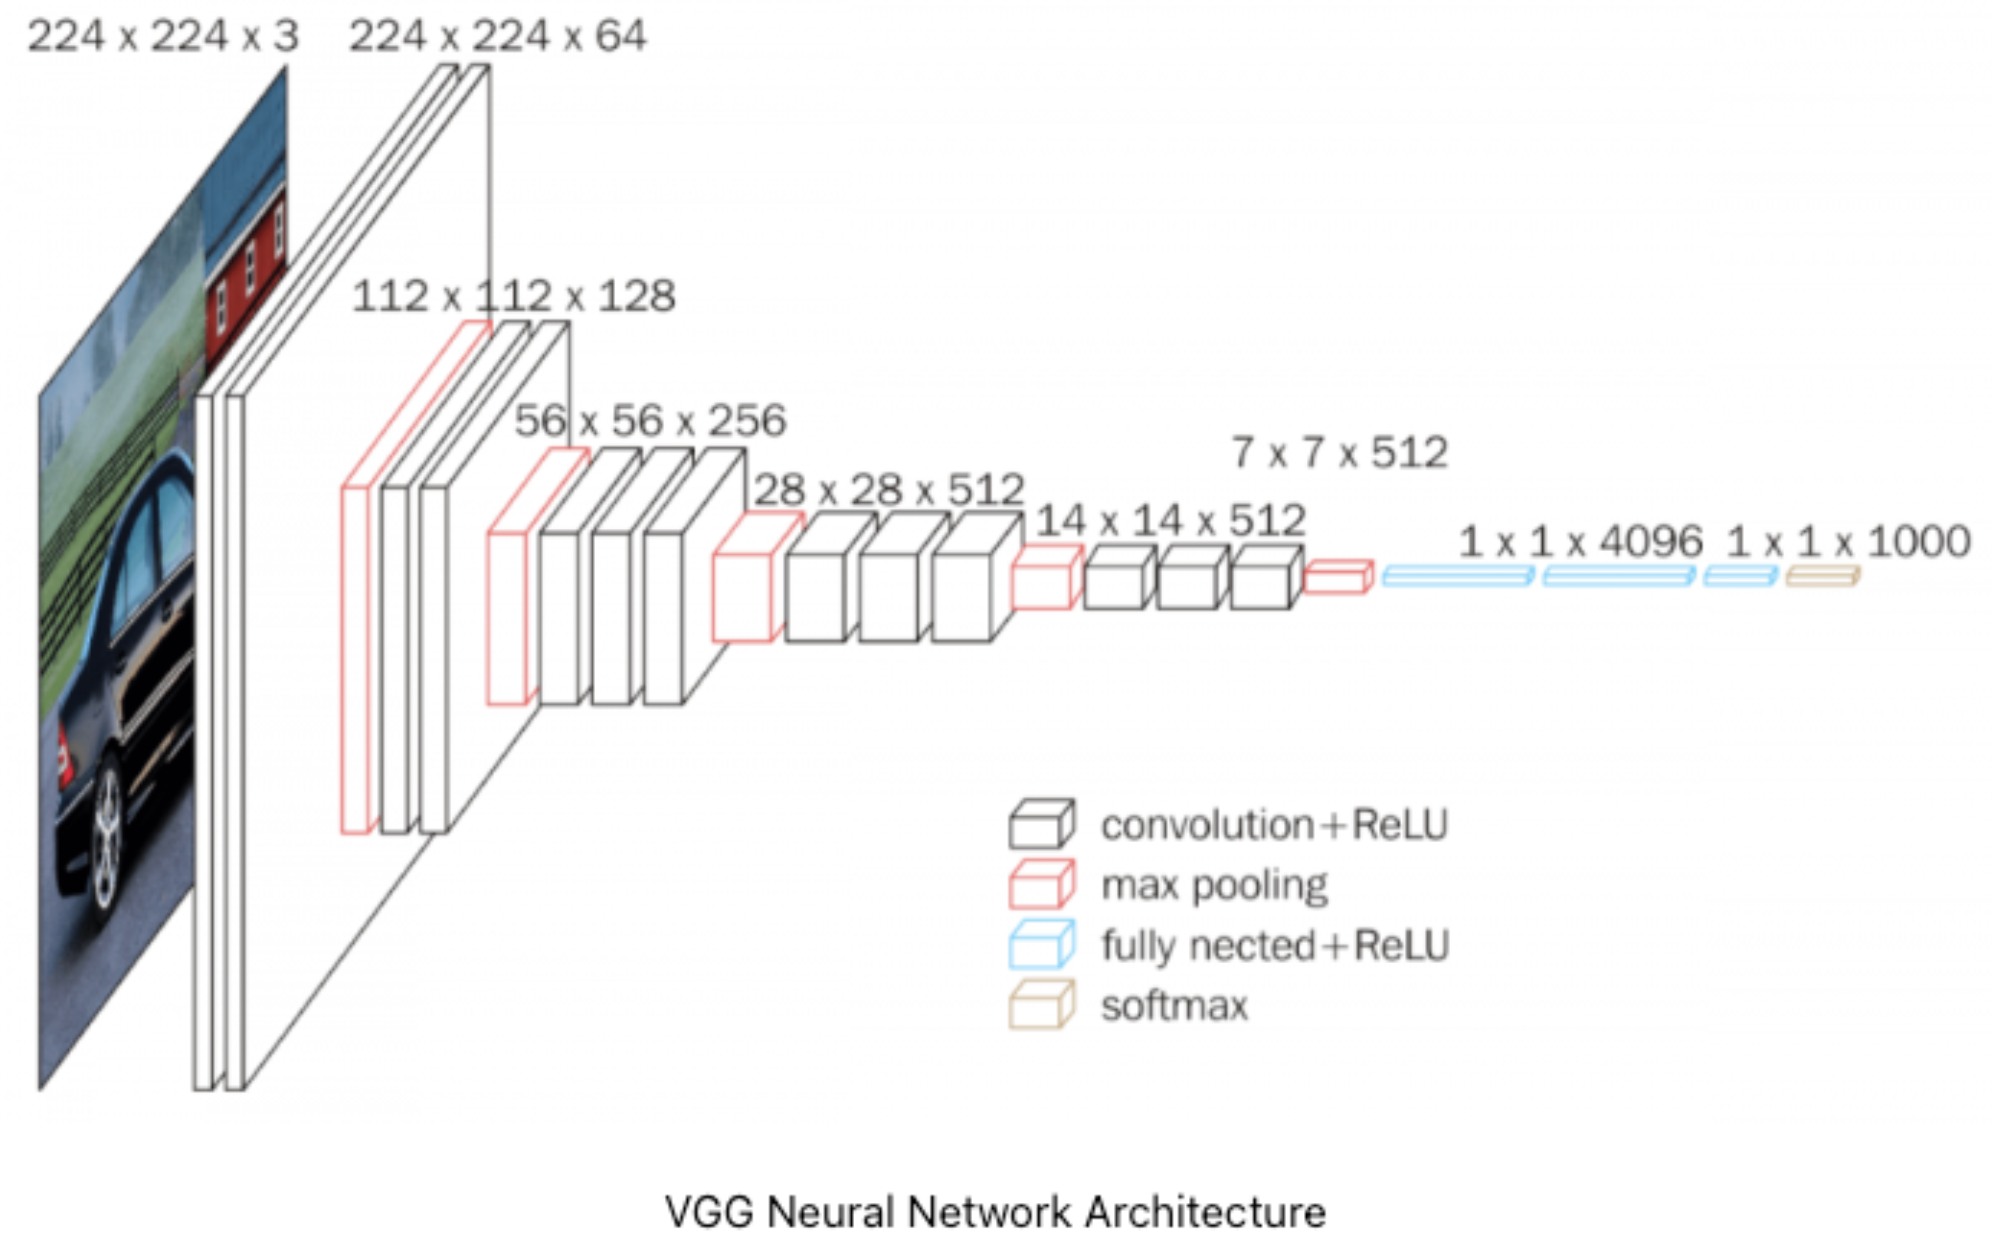

## Create TinyVGG model class

In [19]:
class TinyVGGV1(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [20]:
torch.manual_seed(42)
vgg_model1 = TinyVGGV1(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_dataset.classes)).to(device)
vgg_model1

TinyVGGV1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [21]:
torchinfo.summary(vgg_model1,(32, 3, 64, 64), col_names=["kernel_size", "input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #
TinyVGGV1                                --                        [32, 3, 64, 64]           [32, 3]                   --
├─Sequential: 1-1                        --                        [32, 3, 64, 64]           [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [3, 3]                    [32, 3, 64, 64]           [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         --                        [32, 10, 64, 64]          [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [3, 3]                    [32, 10, 64, 64]          [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         --                        [32, 10, 64, 64]          [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    2                         [32, 10, 64, 64]          [32, 10, 32, 32]          --
├─Sequential: 1-2

## Try a forward pass on a single image (to test the model)

In [22]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
vgg_model1.eval()
with torch.inference_mode():
    pred = vgg_model1(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0787, 0.0686, 0.0387]])

Output prediction probabilities:
tensor([[0.3389, 0.3355, 0.3256]])

Output prediction label:
tensor([0])

Actual label:
0


## Create train & test loop functions

Specifically, we're going to make three functions:
1. `train_step()`: takes in a model, a `DataLoader`, a loss function and an optimizer and trains the model on the `DataLoader`.
2. `test_step()`: takes in a model, a `DataLoader` and a loss function and evaluates the model on the `DataLaoder`.
3. `train()`: performs 1. and 2. together for a given number of epochs and returns a results dictionary.

In [23]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.to(device)
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [24]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device) # X (), y ()

            # 1. Forward pass
            test_pred_logits = model(X) # pred ()

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1) # pred_labes ()
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## Creating a `train()` function to combine `train_step()` and `test_step()`

In [25]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## Train and Evaluate

In [62]:
# Set random seeds
reset_seeds()

# Recreate an instance of TinyVGG
vgg_model1 = TinyVGGV1(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_dataset.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vgg_model1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train
vgg_result1 = train(model=vgg_model1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=30)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0935 | train_acc: 0.4297 | test_loss: 1.1358 | test_acc: 0.2396
Epoch: 2 | train_loss: 1.0227 | train_acc: 0.4609 | test_loss: 1.1243 | test_acc: 0.2500
Epoch: 3 | train_loss: 1.0616 | train_acc: 0.4062 | test_loss: 1.0390 | test_acc: 0.4337
Epoch: 4 | train_loss: 0.9759 | train_acc: 0.4727 | test_loss: 1.0329 | test_acc: 0.4034
Epoch: 5 | train_loss: 0.8679 | train_acc: 0.6641 | test_loss: 1.1159 | test_acc: 0.4138
Epoch: 6 | train_loss: 0.8442 | train_acc: 0.6836 | test_loss: 1.0764 | test_acc: 0.4034
Epoch: 7 | train_loss: 0.8732 | train_acc: 0.5781 | test_loss: 1.0564 | test_acc: 0.4536
Epoch: 8 | train_loss: 0.7156 | train_acc: 0.6758 | test_loss: 0.9870 | test_acc: 0.4744
Epoch: 9 | train_loss: 0.6877 | train_acc: 0.7344 | test_loss: 0.9880 | test_acc: 0.4744
Epoch: 10 | train_loss: 0.6856 | train_acc: 0.7266 | test_loss: 1.0134 | test_acc: 0.4034
Epoch: 11 | train_loss: 0.6154 | train_acc: 0.7734 | test_loss: 1.0164 | test_acc: 0.4025
Epoch: 12 | train_l

## Plot the loss curves of Model

In [63]:
# Check the model_0_results keys
vgg_result1.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [64]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

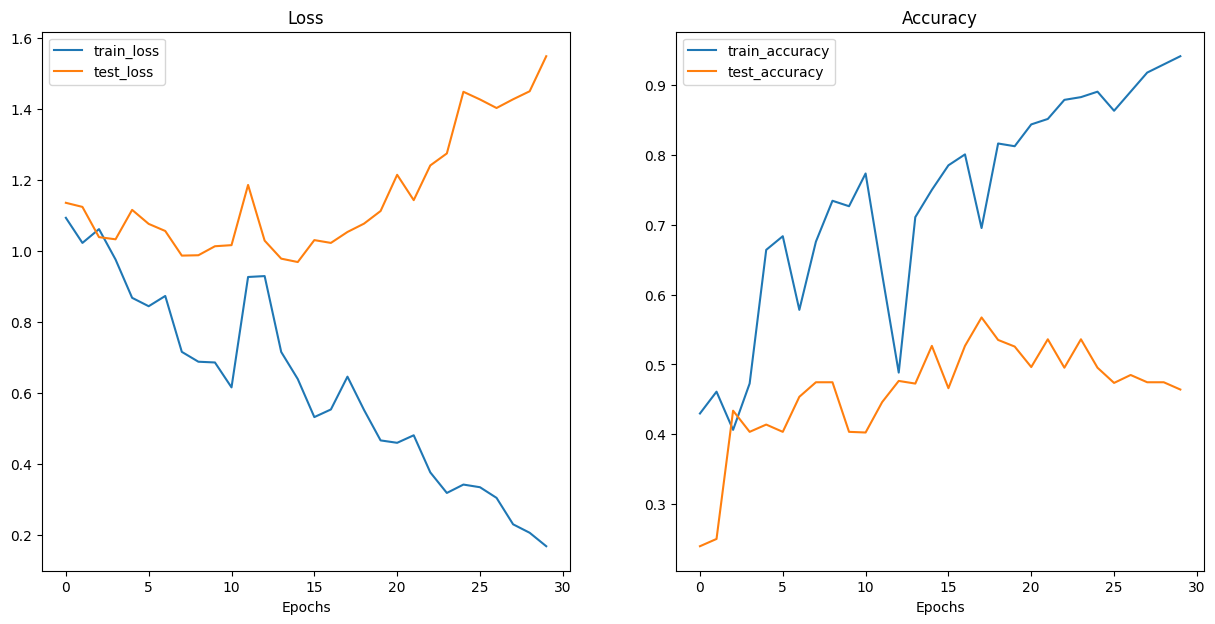

In [65]:
plot_loss_curves(vgg_result1)

# Exploring loss curves
> Loss curves are a great way to see how your model is training/improving over time. Tehy're also a good way to see if your model is underfitting or overfitting.

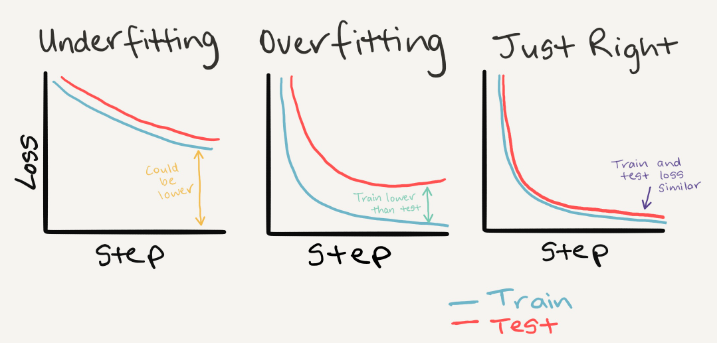

## How to deal with overfitting
A common technique of preventing overfitting is known as [regularization.](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html)   

Let's discuss a few methods to prevnet overfitting.
- Get more data
- Simplify your model
- Use [data augmentation](https://developers.google.com/machine-learning/glossary?hl=ko#data-augmentation)
- Use [transfer learning](https://developers.google.com/machine-learning/glossary?hl=ko#transfer-learning)
- Use dropout layers
- Use learning rate decay
- Use [early stopping](https://developers.google.com/machine-learning/glossary?hl=ko#early_stopping)





# TinyVGG with Early Stopping

## TinyVGG Model

In [30]:
class ConvBlock1(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int) -> None:
        super().__init__()
        self.cnn_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )

    def forward(self, x):

        return self.cnn_block(x)

In [31]:
class ConvBlock2(nn.Module):

    def __init__(self, hidden_units: int) -> None:
        super().__init__()
        self.cnn_block = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):

        return self.cnn_block(x)

In [32]:
class Classifier(nn.Module):

    def __init__(self, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x):

        return self.classifier(x)

In [33]:
class TinyVGGV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = ConvBlock1(input_shape, hidden_units)
        self.conv_block_2 = ConvBlock2(hidden_units)
        self.classifier = Classifier(hidden_units, output_shape)

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [34]:
torch.manual_seed(42)
vgg_model2 = TinyVGGV2(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_dataset.classes)).to(device)
vgg_model2

TinyVGGV2(
  (conv_block_1): ConvBlock1(
    (cnn_block): Sequential(
      (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block_2): ConvBlock2(
    (cnn_block): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Classifier(
    (classifier): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=2560, out_features=3, bias=True)
    )
  )
)

In [35]:
torchinfo.summary(vgg_model2,(32, 3, 64, 64), col_names=["kernel_size", "input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #
TinyVGGV2                                --                        [32, 3, 64, 64]           [32, 3]                   --
├─ConvBlock1: 1-1                        --                        [32, 3, 64, 64]           [32, 10, 32, 32]          --
│    └─Sequential: 2-1                   --                        [32, 3, 64, 64]           [32, 10, 32, 32]          --
│    │    └─Conv2d: 3-1                  [3, 3]                    [32, 3, 64, 64]           [32, 10, 64, 64]          280
│    │    └─ReLU: 3-2                    --                        [32, 10, 64, 64]          [32, 10, 64, 64]          --
│    │    └─Conv2d: 3-3                  [3, 3]                    [32, 10, 64, 64]          [32, 10, 64, 64]          910
│    │    └─ReLU: 3-4                    --                        [32, 10, 64, 64]          [32, 10, 64, 64]          --
│    │    └─MaxPo

## TinyVGG Model_modify

In [66]:
class BaseConvBlock(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int) -> None:
        super().__init__()
        self.cnn_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )

    def forward(self, x):

        return self.cnn_block(x)

In [67]:
class TinyVGGV3(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = BaseConvBlock(input_shape, hidden_units)
        self.conv_block_2 = BaseConvBlock(hidden_units, hidden_units)
        self.classifier = Classifier(hidden_units, output_shape)

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x


In [68]:
torch.manual_seed(42)
vgg_model3 = TinyVGGV3(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_dataset.classes)).to(device)
vgg_model3

TinyVGGV3(
  (conv_block_1): BaseConvBlock(
    (cnn_block): Sequential(
      (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block_2): BaseConvBlock(
    (cnn_block): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Classifier(
    (classifier): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=2560, out_features=3, bias=True)
    )
  )
)

In [69]:
torchinfo.summary(vgg_model3,(32, 3, 64, 64), col_names=["kernel_size", "input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #
TinyVGGV3                                --                        [32, 3, 64, 64]           [32, 3]                   --
├─BaseConvBlock: 1-1                     --                        [32, 3, 64, 64]           [32, 10, 32, 32]          --
│    └─Sequential: 2-1                   --                        [32, 3, 64, 64]           [32, 10, 32, 32]          --
│    │    └─Conv2d: 3-1                  [3, 3]                    [32, 3, 64, 64]           [32, 10, 64, 64]          280
│    │    └─ReLU: 3-2                    --                        [32, 10, 64, 64]          [32, 10, 64, 64]          --
│    │    └─Conv2d: 3-3                  [3, 3]                    [32, 10, 64, 64]          [32, 10, 64, 64]          910
│    │    └─ReLU: 3-4                    --                        [32, 10, 64, 64]          [32, 10, 64, 64]          --
│    │    └─MaxPo

## Engine

### EarnlyStopper

In [36]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.best_loss = np.inf
        self.save_path = save_path

    def is_continuable(self, model, loss):
        if loss < self.best_loss: # 현재 loss가 최고 loss보다 더 낮은 경우
            self.best_loss = loss # 최고 loss를 현재 loss로 업데이트
            self.trial_counter = 0 # 초기화
            torch.save(model, self.save_path) # 최고 loss를 갖은 모델 저장
            return True
        elif self.trial_counter + 1 < self.num_trials: # 현재 loss가 최고 loss보다 작은 경우 & max 시도횟수보다 현재 시도횟수가 작은 경우
            self.trial_counter += 1 # 기존 시도횟수 + 1
            return True
        else: # 현재 정확도가 최고 정확도보다 작은 경우 & 현재 시도횟수가 max 시도횟수보다 큰 경우
            return False

    def get_best_model(self, device):
        return torch.load(self.save_path).to(device)


### Train Step

In [37]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

### Test Step

In [38]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device) # X (), y ()

            # 1. Forward pass
            test_pred_logits = model(X) # pred ()

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1) # pred_labes ()
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### Main

In [39]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def main(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          early_stopper,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # 6. early stopper
        if not early_stopper.is_continuable(model, test_loss):
            print(f'validation: best loss: {early_stopper.best_loss}')
            break

    # 7. Return the filled results at the end of the epochs
    return results

## Training

In [40]:
# Set random seeds
reset_seeds()


# Recreate an instance of TinyVGG
vgg_model2 = TinyVGGV2(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_dataset.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vgg_model2.parameters(), lr=0.001)

early_stopper = EarlyStopper(num_trials=args.NUM_TRIALS, save_path=args.vgg_best_model)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train
vgg_result2 = main(model=vgg_model2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        early_stopper=early_stopper,
                        loss_fn=loss_fn,
                        epochs=args.NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0935 | train_acc: 0.4297 | test_loss: 1.1358 | test_acc: 0.2396
Epoch: 2 | train_loss: 1.0227 | train_acc: 0.4609 | test_loss: 1.1243 | test_acc: 0.2500
Epoch: 3 | train_loss: 1.0616 | train_acc: 0.4062 | test_loss: 1.0390 | test_acc: 0.4337
Epoch: 4 | train_loss: 0.9759 | train_acc: 0.4727 | test_loss: 1.0329 | test_acc: 0.4034
Epoch: 5 | train_loss: 0.8679 | train_acc: 0.6641 | test_loss: 1.1159 | test_acc: 0.4138
Epoch: 6 | train_loss: 0.8442 | train_acc: 0.6836 | test_loss: 1.0764 | test_acc: 0.4034
Epoch: 7 | train_loss: 0.8732 | train_acc: 0.5781 | test_loss: 1.0564 | test_acc: 0.4536
Epoch: 8 | train_loss: 0.7156 | train_acc: 0.6758 | test_loss: 0.9870 | test_acc: 0.4744
Epoch: 9 | train_loss: 0.6877 | train_acc: 0.7344 | test_loss: 0.9880 | test_acc: 0.4744
Epoch: 10 | train_loss: 0.6856 | train_acc: 0.7266 | test_loss: 1.0134 | test_acc: 0.4034
Epoch: 11 | train_loss: 0.6154 | train_acc: 0.7734 | test_loss: 1.0164 | test_acc: 0.4025
Epoch: 12 | train_l

In [41]:
# Check the model_0_results keys
vgg_result2.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

### Plot the loss curves of Model

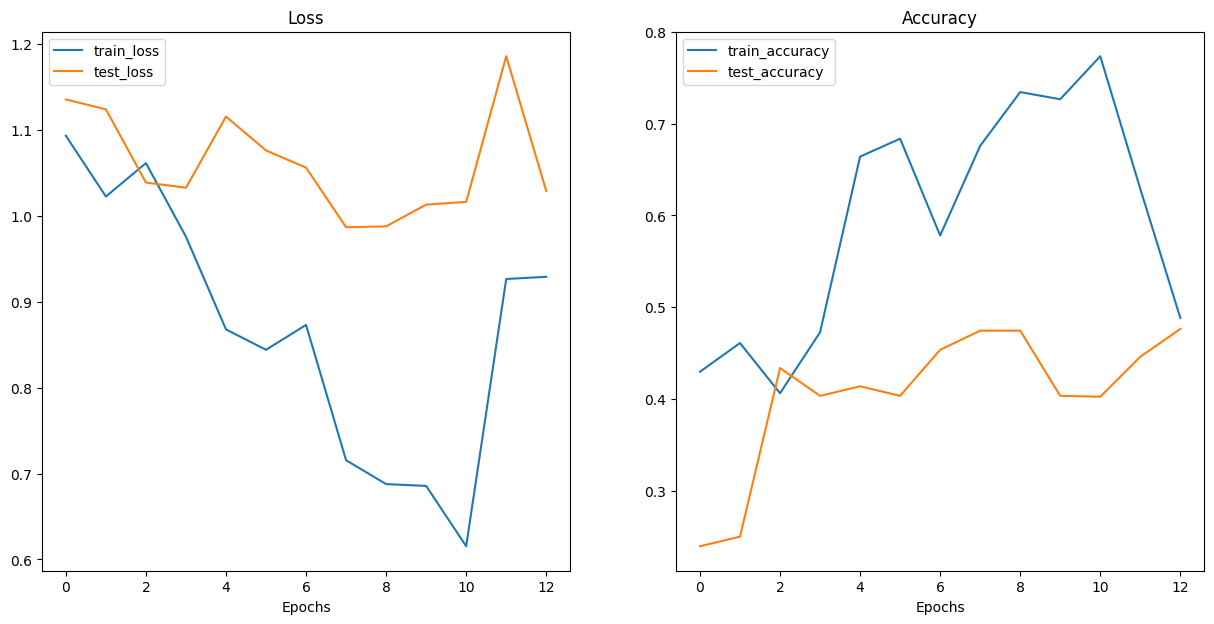

In [42]:
plot_loss_curves(vgg_result2)

# ResNet with Early Stopping

## VGG 단점
- 기존의 deep learning network는 8 layers 수준이었다면, VGG는 19 layers까지 테스트를 하며, layers 수가 늘어날 수록 성능이 더 좋아진다는 것을 보여주었습니다.  

하지만 아래 이미지와 같이 layers를 무조건 늘리는 것이 성능을 좋게 하지 않습니다.

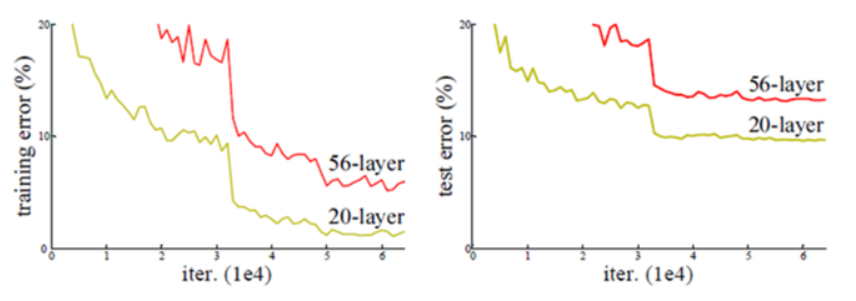

## What is ResNet?
VGG와 같이 일반적인 CNN 망은 아래와 같이 입력 x를 받아 2개의 weighted layer를 거쳐 출력 H(x)를 내며, 다음 layer의 입력으로 사용됩니다.

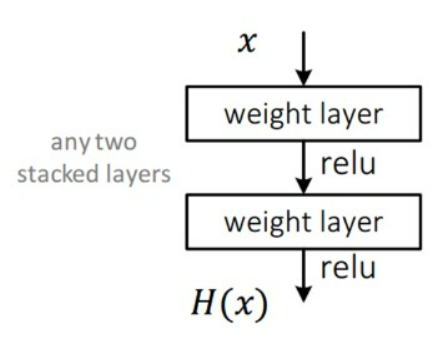

아래 이미지와 같이 ResNet은 layer의 입력을 layer의 출력에 바로 연결 시키는 'skip connection'을 사용했습니다. 이미지를 보면 출력 H(x)가 F(x) + x로 변경된 것을 볼 수 있습니다. 이렇게 단순히 weight layer를 통해 나온 결과와 그 전 결과를 더하고 relu를 사용한 것 뿐이지만, 그 성능은 매우 대단했습니다.   


그 이유는 기존의 모델은 H(x)를 얻기 위한 학습을 했다면, ResNet은 F(x)가 0이 되는 방향으로 학습을 합니다. 즉 F(x) = H(x) - x고, F(x)를 학습한다는 건 나머지(residual)을 학습한다고 볼 수 있고, 그래서 이름이 ResNet이 된 것입니다.

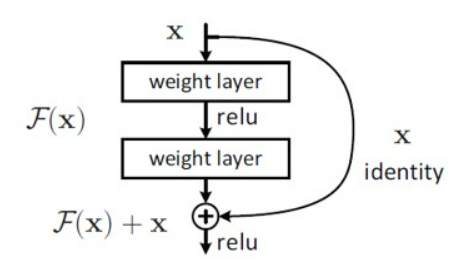

### ResNet Model 전체구조

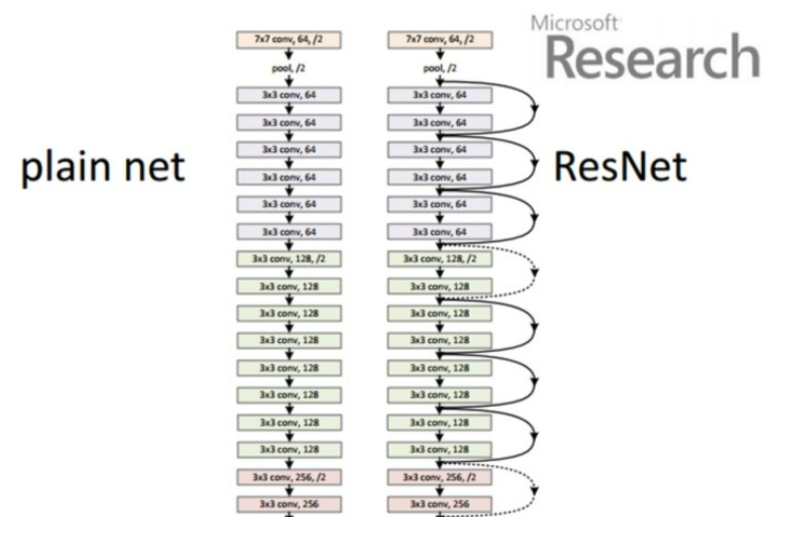

## ResNet Model

In [43]:
import torch.nn.functional as F

In [44]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out1 = F.relu(self.bn1(self.conv1(x)))
        out2 = self.bn2(self.conv2(out1))
        out2 += self.shortcut(x)
        out = F.relu(out2)
        return out

In [45]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(2048*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [46]:
def ResNet18(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

In [47]:
torch.manual_seed(42)
resnet_model = ResNet18(len(train_dataset.classes)).to(device)
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [48]:
torchinfo.summary(resnet_model,(32, 3, 64, 64), col_names=["kernel_size", "input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #
ResNet                                   --                        [32, 3, 64, 64]           [32, 3]                   --
├─Conv2d: 1-1                            [3, 3]                    [32, 3, 64, 64]           [32, 64, 64, 64]          1,728
├─BatchNorm2d: 1-2                       --                        [32, 64, 64, 64]          [32, 64, 64, 64]          128
├─Sequential: 1-3                        --                        [32, 64, 64, 64]          [32, 64, 64, 64]          --
│    └─BasicBlock: 2-1                   --                        [32, 64, 64, 64]          [32, 64, 64, 64]          --
│    │    └─Conv2d: 3-1                  [3, 3]                    [32, 64, 64, 64]          [32, 64, 64, 64]          36,864
│    │    └─BatchNorm2d: 3-2             --                        [32, 64, 64, 64]          [32, 64, 64, 64]          128
│    │    

## Training

In [49]:
# Set random seeds
reset_seeds()


resnet_model = ResNet18(len(train_dataset.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet_model.parameters(), lr=0.001)

early_stopper = EarlyStopper(num_trials=args.NUM_TRIALS, save_path=args.resnet_best_model)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train
resnet_result = main(model=resnet_model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        early_stopper=early_stopper,
                        loss_fn=loss_fn,
                        epochs=args.NUM_EPOCHS
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0575 | train_acc: 0.3516 | test_loss: 22.4215 | test_acc: 0.2708
Epoch: 2 | train_loss: 1.3086 | train_acc: 0.4453 | test_loss: 4.0370 | test_acc: 0.4716
Epoch: 3 | train_loss: 0.9138 | train_acc: 0.4844 | test_loss: 4.8545 | test_acc: 0.3712
Epoch: 4 | train_loss: 0.8136 | train_acc: 0.7070 | test_loss: 2.5520 | test_acc: 0.4631
Epoch: 5 | train_loss: 0.7363 | train_acc: 0.7461 | test_loss: 2.7640 | test_acc: 0.4536
Epoch: 6 | train_loss: 1.0733 | train_acc: 0.5703 | test_loss: 1.5527 | test_acc: 0.5152
Epoch: 7 | train_loss: 0.7291 | train_acc: 0.7148 | test_loss: 7.5412 | test_acc: 0.3778
Epoch: 8 | train_loss: 0.8040 | train_acc: 0.7148 | test_loss: 6.5015 | test_acc: 0.4915
Epoch: 9 | train_loss: 0.9190 | train_acc: 0.6055 | test_loss: 7.3870 | test_acc: 0.5833
Epoch: 10 | train_loss: 1.7584 | train_acc: 0.5898 | test_loss: 3.6055 | test_acc: 0.3419
Epoch: 11 | train_loss: 1.5131 | train_acc: 0.4805 | test_loss: 9.5232 | test_acc: 0.2917
validation: best l

### Plot the loss curves of Model

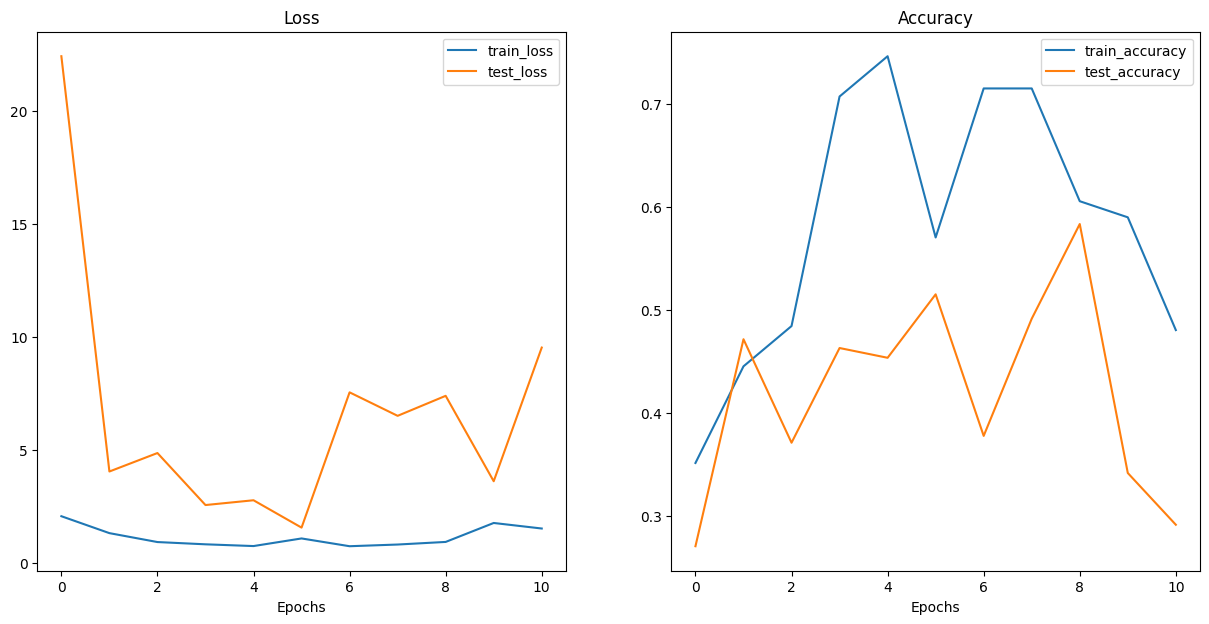

In [50]:
plot_loss_curves(resnet_result)

# Compare model results

In [51]:
import pandas as pd

In [52]:
df_vgg = pd.DataFrame(vgg_result2)
df_vgg

,train_loss,train_acc,test_loss,test_acc
0,1.093534,0.429688,1.135838,0.239583
1,1.022740,0.460938,1.124282,0.250000
2,1.061649,0.406250,1.039028,0.433712
3,0.975933,0.472656,1.032940,0.403409
4,0.867919,0.664062,1.115924,0.413826
5,0.844214,0.683594,1.076395,0.403409
6,0.873165,0.578125,1.056375,0.453598
7,0.715555,0.675781,0.986956,0.474432
8,0.687731,0.734375,0.987972,0.474432
9,0.685621,0.726562,1.013354,0.403409


In [53]:
df_resnet = pd.DataFrame(resnet_result)
df_resnet

,train_loss,train_acc,test_loss,test_acc
0,2.057527,0.351562,22.421455,0.270833
1,1.308569,0.445312,4.036961,0.471591
2,0.913787,0.484375,4.854543,0.371212
3,0.813586,0.707031,2.551988,0.463068
4,0.736277,0.746094,2.763959,0.453598
5,1.073331,0.570312,1.552699,0.515152
6,0.729137,0.714844,7.541215,0.377841
7,0.804009,0.714844,6.501509,0.491477
8,0.918991,0.605469,7.387001,0.583333
9,1.758390,0.589844,3.605470,0.341856


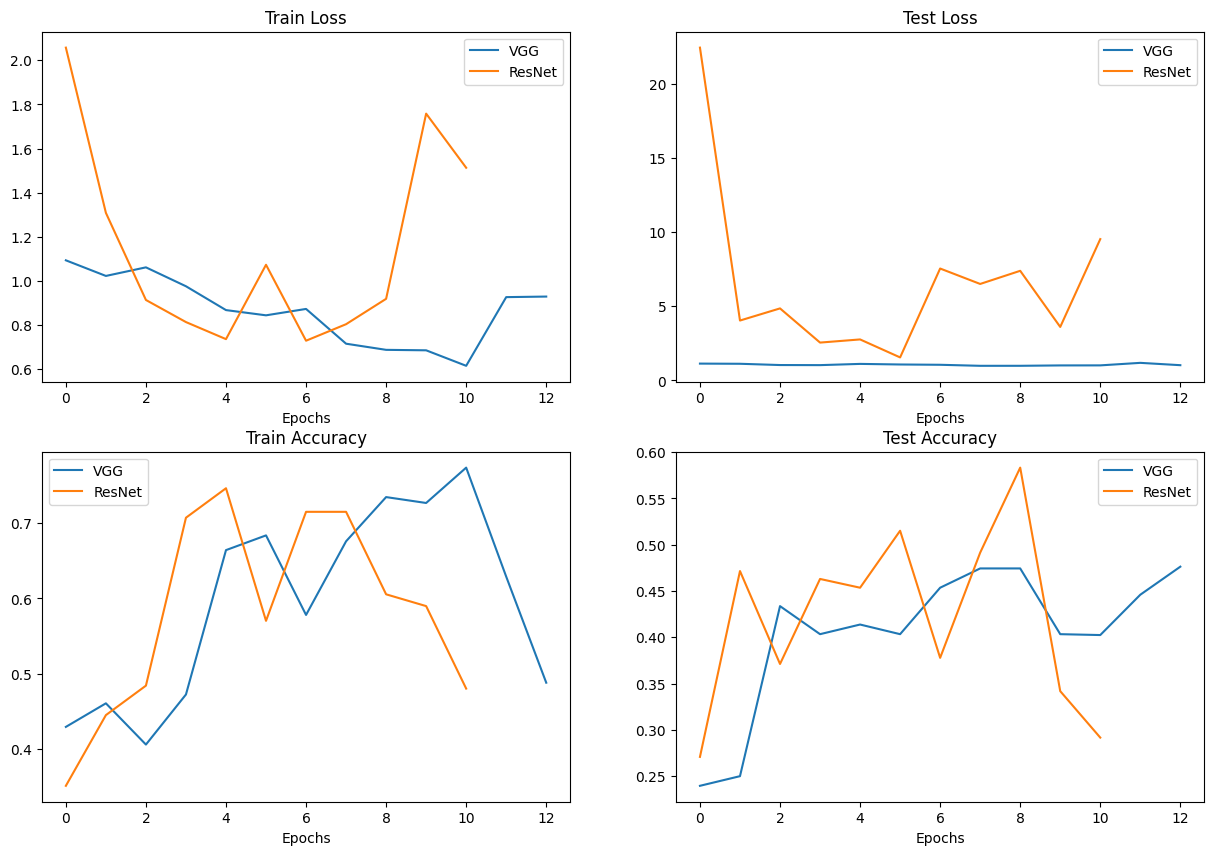

In [54]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
vgg_epochs = range(len(df_vgg))
resnet_epochs = range(len(df_resnet))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(vgg_epochs, df_vgg["train_loss"], label="VGG")
plt.plot(resnet_epochs, df_resnet["train_loss"], label="ResNet")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(vgg_epochs, df_vgg["test_loss"], label="VGG")
plt.plot(resnet_epochs, df_resnet["test_loss"], label="ResNet")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(vgg_epochs, df_vgg["train_acc"], label="VGG")
plt.plot(resnet_epochs, df_resnet["train_acc"], label="ResNet")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(vgg_epochs, df_vgg["test_acc"], label="VGG")
plt.plot(resnet_epochs, df_resnet["test_acc"], label="ResNet")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

# Making a prediction on a custom image

## Loading in a custom image

In [55]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [56]:
import torchvision

# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
# print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dtype: torch.float32


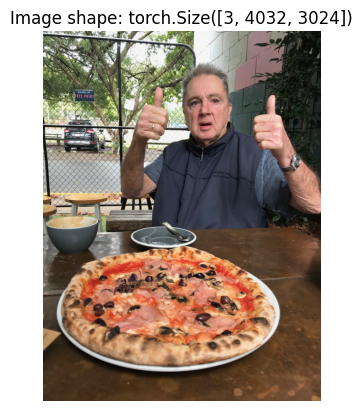

In [57]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

## Predicting on custom images with the best trained model

In [58]:
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image
    target_image = Image.open(image_path)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    # target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

In [59]:
# Get class names as a list
class_names = train_dataset.classes
class_names

['pizza', 'steak', 'sushi']

### VGG Best Model

<ipython-input-60-887b2b8a7d95>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg_best_model = torch.load(args.vgg_best_model).to(device)


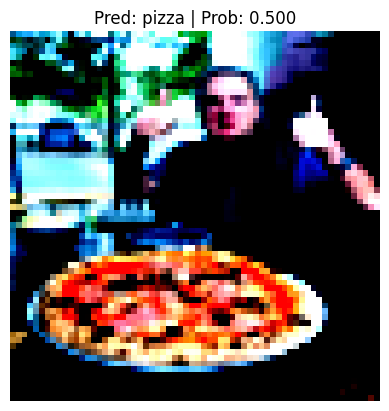

In [60]:
vgg_best_model = torch.load(args.vgg_best_model).to(device)

pred_and_plot_image(model=vgg_best_model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=test_transform,
                    device=device)

### ResNet Best Model

<ipython-input-61-32ce2d88e593>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_best_model = torch.load(args.resnet_best_model).to(device)


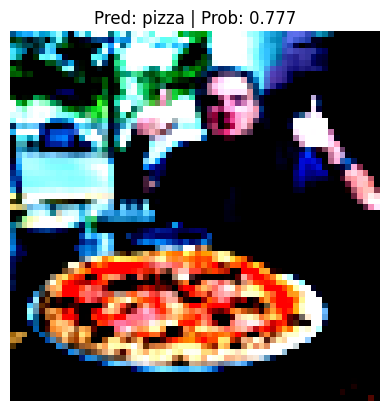

In [61]:
resnet_best_model = torch.load(args.resnet_best_model).to(device)

pred_and_plot_image(model=resnet_best_model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=test_transform,
                    device=device)